In [5]:
# Initialisierung und Daten laden

# Imports
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy.spatial import distance
from pathlib import Path
import json

# Farbdefinitionen
party_colors = {
    "CDU/CSU": "#000000",
    "AfD": "#0056FF",
    "SPD": "#E3000F",
    "B90/GRÜNE": "#1FA12E",
    "LINKE": "#A3488A",
    "BSW": "#D77AFF",
    "FDP": "#FFED00",
    "FW": "#FF9900",
    "Sonstige": "#B0B0B0"
}

# Stance-Daten
DATA_PATH1 = r"E:\Final_Github_1\MasterThesis_final\data\processed\preprocessing\mirror\mirror_llama_final.csv"
DATA_PATH2 = r"E:\Final_Github_1\MasterThesis_final\data\processed\preprocessing\augmentation\augmentation_llama_final.csv"

df_mirror = pd.read_csv(DATA_PATH1, sep=";", encoding="utf-8-sig", dtype={"timestamp": str})
df_aug    = pd.read_csv(DATA_PATH2, sep=";", encoding="utf-8-sig", dtype={"timestamp": str})

cdu_variants = ["CDU", "CSU", "CDU/CSU"]
for df in [df_mirror, df_aug]:
    if "party" in df.columns:
        df["party"] = df["party"].replace(cdu_variants, "CDU/CSU")

df_mirror["source"] = "Mirror"
df_aug["source"]    = "Augmentation"
df_all = pd.concat([df_mirror, df_aug], ignore_index=True)

# Poll-Daten
POLL_PATH = Path(r"E:\Final_Github_1\MasterThesis_final\data\raw\list\polls")
poll_files = list(POLL_PATH.glob("*.csv"))
polls_all = pd.concat(
    [pd.read_csv(f, sep=";", encoding="utf-8-sig", dtype=str).assign(source_file=f.name) for f in poll_files],
    ignore_index=True
)

# Election Results
ELECTION_PATH = Path(r"E:\Final_Github_1\MasterThesis_final\data\raw\list\election_results_2021_2025.csv")
election_results = pd.read_csv(ELECTION_PATH, sep=";", encoding="utf-8-sig", dtype=str)

# Jensen-Shannon Divergenz
def jensen_shannon(p, q):
    p = np.array(p, dtype=float); p = p / p.sum() if p.sum() != 0 else p
    q = np.array(q, dtype=float); q = q / q.sum() if q.sum() != 0 else q
    m = 0.5 * (p + q)
    p = np.where(p == 0, 1e-12, p)
    q = np.where(q == 0, 1e-12, q)
    m = np.where(m == 0, 1e-12, m)
    kl_pm = np.sum(p * np.log(p / m))
    kl_qm = np.sum(q * np.log(q / m))
    return 0.5 * (kl_pm + kl_qm)

# Export-Pfad für Analysen
EXPORT_PATH = Path(r"E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2")
EXPORT_PATH.mkdir(parents=True, exist_ok=True)

# Hilfsfunktionen zum Speichern
def save_df(df: pd.DataFrame, filename: str):
    """Speichert einen DataFrame im EXPORT_PATH."""
    out_path = EXPORT_PATH / filename
    df.to_csv(out_path, sep=";", index=False, encoding="utf-8-sig")
    print(f"[OK] DataFrame gespeichert: {out_path}")

def save_json(obj: dict, filename: str):
    """Speichert ein Dictionary/Objekt als JSON im EXPORT_PATH."""
    out_path = EXPORT_PATH / filename
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)
    print(f"[OK] JSON gespeichert: {out_path}")

print("Initialisierung abgeschlossen")
print("Stance Mirror:", df_mirror.shape, "| Stance Aug:", df_aug.shape, "| Gesamt:", df_all.shape)
print("Poll-Dateien geladen:", len(poll_files), "| Polls Shape:", polls_all.shape)
print("Election Results Shape:", election_results.shape)
print("Export-Pfad:", EXPORT_PATH)


Initialisierung abgeschlossen
Stance Mirror: (772378, 15) | Stance Aug: (493426, 15) | Gesamt: (1265804, 15)
Poll-Dateien geladen: 7 | Polls Shape: (113, 15)
Election Results Shape: (7, 4)
Export-Pfad: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2


In [6]:
# Berechnung der Online-Metriken pro Partei (inkl. korrigiertem ASI)

metrics = []
total_tweets = len(df_all)

# Zähle pro User, wie viele Zustimmungen zu jeder Partei existieren
user_party_support = (
    df_all[df_all["pred"] == "Zustimmung"]
    .groupby(["username", "party"])
    .size()
    .reset_index(name="support_count")
)

# Finde alle assigned users (mindestens 3 Zustimmungen für irgendeine Partei)
assigned_global = user_party_support[user_party_support["support_count"] >= 3]["username"].unique()
total_assigned_users = len(assigned_global)

for party, group in df_all.groupby("party"):
    S = (group["pred"] == "Zustimmung").sum()
    R = (group["pred"] == "Ablehnung").sum()
    N = (group["pred"] == "Neutral").sum()
    T = len(group)

    # Volume Index (VI)
    VI = T / total_tweets if total_tweets > 0 else 0

    # Net Stance Index (NSI)
    NSI = (S - R) / (S + R + N) if (S + R + N) > 0 else 0

    # Support Ratio (SR)
    SR = S / (S + R) if (S + R) > 0 else 0

    # Weighted Stance Index (WSI)
    WSI = NSI * VI

    # Assigned Supporter Index (ASI)
    assigned_users_party = user_party_support[
        (user_party_support["party"] == party) & (user_party_support["support_count"] >= 3)
    ]["username"].nunique()
    ASI = assigned_users_party / total_assigned_users if total_assigned_users > 0 else 0

    metrics.append([party, VI, NSI, SR, WSI, ASI, S, R])

metrics_df = pd.DataFrame(
    metrics,
    columns=["party", "VI", "NSI", "SR", "WSI", "ASI", "SupportSum", "RejectSum"]
)

# Support/Reject Distribution
total_support = metrics_df["SupportSum"].sum()
total_reject = metrics_df["RejectSum"].sum()
metrics_df["SupportDist"] = metrics_df["SupportSum"] / total_support if total_support > 0 else 0
metrics_df["RejectDist"] = metrics_df["RejectSum"] / total_reject if total_reject > 0 else 0

print(metrics_df)

# Ergebnisse nur als CSV speichern
csv_path = EXPORT_PATH / "metrics_per_party.csv"
metrics_df.to_csv(csv_path, sep=";", index=False, encoding="utf-8-sig")

print(f"[OK] Metriken gespeichert: {csv_path}")




       party        VI       NSI        SR       WSI       ASI  SupportSum  \
0        AfD  0.127409 -0.432938  0.251548 -0.055160  0.285985       35346   
1  B90/GRÜNE  0.219859 -0.661995  0.127387 -0.145545  0.257855       31492   
2        BSW  0.040796 -0.632727  0.128468 -0.025813  0.037007        5649   
3    CDU/CSU  0.359797 -0.706180  0.103872 -0.254081  0.419152       42167   
4        FDP  0.110122 -0.622298  0.147520 -0.068529  0.137855       18152   
5      LINKE  0.039635 -0.625015  0.141216 -0.024772  0.053965        6171   
6        SPD  0.102382 -0.739141  0.086164 -0.075674  0.057456        9972   

   RejectSum  SupportDist  RejectDist  
0     105168     0.237303    0.108288  
1     215724     0.211428    0.222125  
2      38323     0.037926    0.039460  
3     363784     0.283097    0.374578  
4     104896     0.121867    0.108008  
5      37528     0.041430    0.038641  
6     105761     0.066949    0.108899  
[OK] Metriken gespeichert: E:\Final_Github_1\MasterThes

In [7]:
# KL- und JSD-Berechnung: Online-Metriken vs. Wahlergebnisse 2025

from scipy.spatial import distance
import json

# Hilfsfunktionen
def kl_divergence(p, q):
    p = np.array(p, dtype=float); q = np.array(q, dtype=float)
    p = p / p.sum() if p.sum() != 0 else np.ones_like(p) / len(p)
    q = q / q.sum() if q.sum() != 0 else np.ones_like(q) / len(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def jensen_shannon(p, q):
    p = np.array(p, dtype=float); q = np.array(q, dtype=float)
    if np.isnan(p).any() or np.isnan(q).any():
        return np.nan
    p = p / p.sum() if p.sum() != 0 else np.ones_like(p) / len(p)
    q = q / q.sum() if q.sum() != 0 else np.ones_like(q) / len(q)
    m = 0.5 * (p + q)
    return 0.5 * distance.rel_entr(p, m).sum() + 0.5 * distance.rel_entr(q, m).sum()

# Wahlergebnisse vorbereiten
election_results = pd.read_csv(
    r"E:\Final_Github_1\MasterThesis_final\data\raw\list\election_results_2021_2025.csv",
    sep=";", encoding="utf-8-sig"
)
election_results["vote_share_2025"] = (
    election_results["vote_share_2025"]
    .astype(str).str.replace(",", ".", regex=False).str.strip()
)
election_results["vote_share_2025"] = pd.to_numeric(
    election_results["vote_share_2025"], errors="coerce"
)

# Merge Metrics + Election Results
df_compare = metrics_df.merge(election_results[["party", "vote_share_2025"]], on="party", how="inner")

# Nur Verteilungen testen
distribution_metrics = ["VI", "ASI", "SupportDist", "RejectDist"]

results = []
for metric in distribution_metrics:
    P = df_compare[metric].values
    Q = df_compare["vote_share_2025"].values

    kl_val = kl_divergence(P, Q)
    jsd_val = jensen_shannon(P, Q)

    results.append({
        "metric": metric,
        "KL": round(kl_val, 4),
        "JSD": round(jsd_val, 4)
    })

results_df = pd.DataFrame(results)

# Export Ergebnisse
csv_path = EXPORT_PATH / "kl_jsd_results.csv"
json_path = EXPORT_PATH / "kl_jsd_results.json"

results_df.to_csv(csv_path, sep=";", index=False, encoding="utf-8-sig")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("KL- und JSD-Divergenz gegen Wahl 2025")
display(results_df)
print(f"[OK] Ergebnisse gespeichert: {csv_path}")
print(f"[OK] Ergebnisse gespeichert: {json_path}")


KL- und JSD-Divergenz gegen Wahl 2025


,metric,KL,JSD
0,VI,0.1303,0.0318
1,ASI,0.1478,0.0387
2,SupportDist,0.1345,0.0331
3,RejectDist,0.1426,0.0353


[OK] Ergebnisse gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\kl_jsd_results.csv
[OK] Ergebnisse gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\kl_jsd_results.json


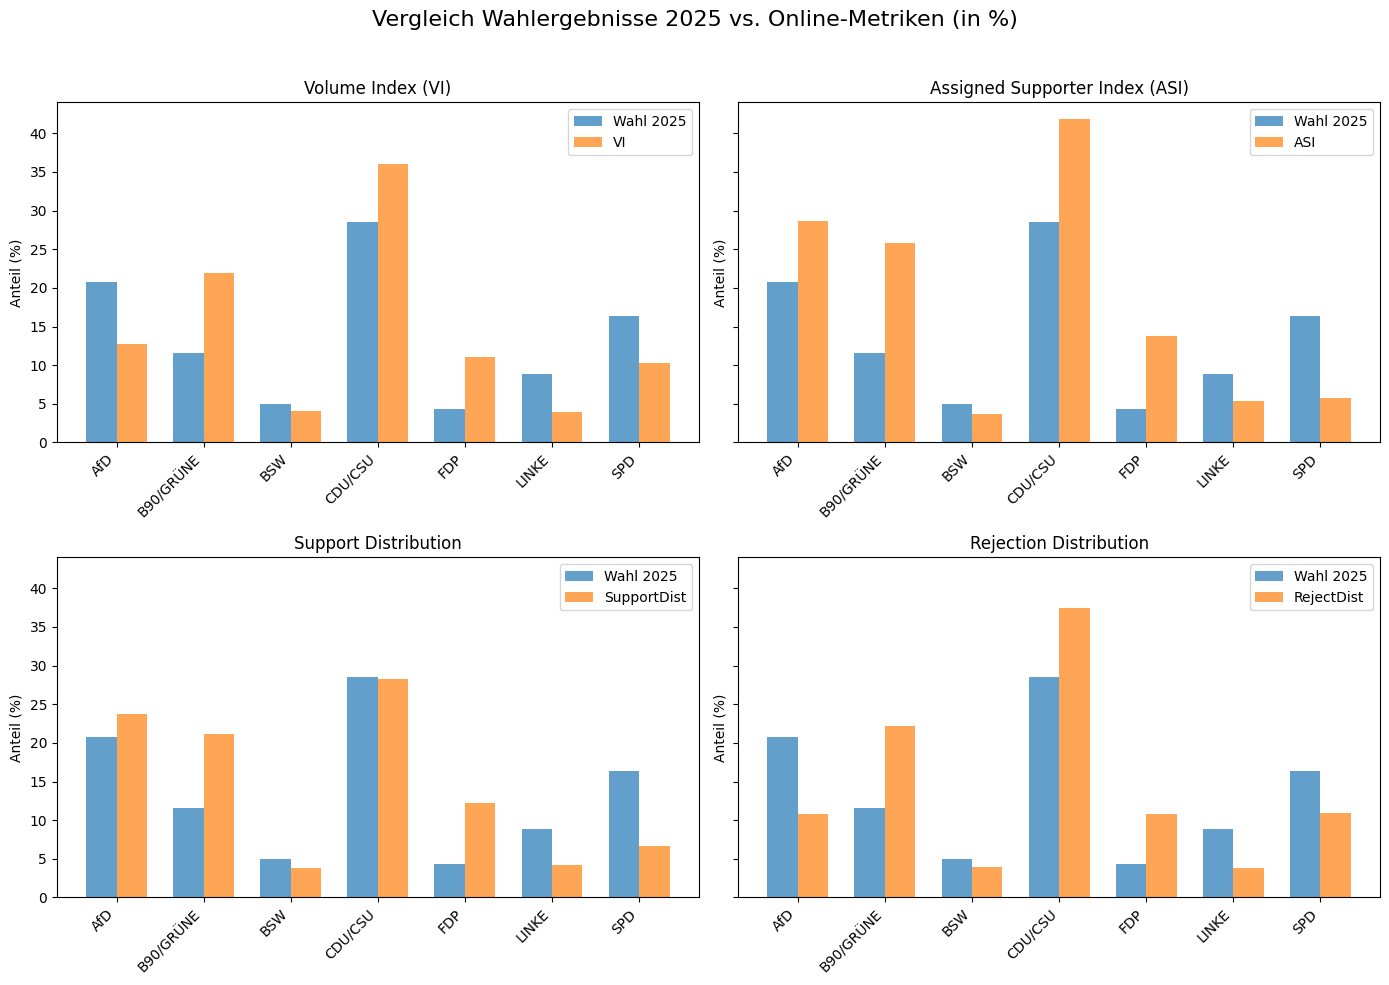

[OK] Plot gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\vergleich_wahl_vs_metriken.png


In [8]:
# Vergleichsplots: Wahlergebnis 2025 vs. Online-Metriken (in %)

import matplotlib.pyplot as plt

# Falls Wahlwerte noch in Prozent (0–100) sind, auf 0–1 normalisieren
vote_share = df_compare["vote_share_2025"].copy()
if vote_share.max() > 1:
    vote_share = vote_share / 100.0

metrics = ["VI", "ASI", "SupportDist", "RejectDist"]
titles = ["Volume Index (VI)", "Assigned Supporter Index (ASI)",
          "Support Distribution", "Rejection Distribution"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    width = 0.35
    x = range(len(df_compare))

    # Werte in %
    election_pct = vote_share * 100
    metric_pct = df_compare[metric] * 100

    ax.bar(x, election_pct, width, label="Wahl 2025", alpha=0.7)
    ax.bar([i + width for i in x], metric_pct, width, label=metric, alpha=0.7)

    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(df_compare["party"], rotation=45, ha="right")
    ax.set_ylabel("Anteil (%)")
    ax.set_title(title)
    ax.legend()

fig.suptitle("Vergleich Wahlergebnisse 2025 vs. Online-Metriken (in %)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Export als PNG
plot_path = EXPORT_PATH / "vergleich_wahl_vs_metriken.png"
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"[OK] Plot gespeichert: {plot_path}")



In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Ensure numeric (Komma → Punkt)
df_compare["vote_share_2025"] = (
    df_compare["vote_share_2025"]
    .astype(str)
    .str.replace(",", ".")
    .astype(float)
)

# Ensure election results are in percent
vote_share = df_compare["vote_share_2025"].copy()
if vote_share.max() <= 1:
    vote_share = vote_share * 100

metrics = ["VI", "ASI", "SupportDist", "RejectDist"]
titles = ["Volume Index (VI)", "Assigned Supporter Index (ASI)",
          "Support Distribution", "Opposition Distribution"]

# Weniger Abstand zwischen Subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=titles,
    shared_yaxes=True,
    vertical_spacing=0.20,
    horizontal_spacing=0.09
)

for i, (metric, title) in enumerate(zip(metrics, titles)):
    row = i // 2 + 1
    col = i % 2 + 1

    election_pct = vote_share
    metric_pct = df_compare[metric] * 100

    fig.add_trace(
        go.Bar(
            x=df_compare["party"],
            y=election_pct,
            name="Election 2025",
            marker_color="#005AA9",
            opacity=0.9,
            showlegend=(i == 0)
        ),
        row=row, col=col
    )

    fig.add_trace(
        go.Bar(
            x=df_compare["party"],
            y=metric_pct,
            name="Online metric",
            marker_color="orange",
            opacity=0.8,
            showlegend=(i == 0)
        ),
        row=row, col=col
    )

fig.update_layout(
    barmode="group",
    height=700,
    width=950,
    legend=dict(orientation="h", y=-0.1),
    title=None,
    bargap=0.15
)

fig.update_yaxes(title_text="Share (%)")

# Anzeigen
fig.show()

# Export
plot_html = EXPORT_PATH / "vergleich_wahl_vs_metriken_interaktiv.html"
plot_png  = EXPORT_PATH / "vergleich_wahl_vs_metriken.png"

fig.write_html(plot_html)
fig.write_image(plot_png, scale=2)  # requires kaleido

print(f"[OK] Interaktiver Plot gespeichert: {plot_html}")
print(f"[OK] Statischer Plot gespeichert: {plot_png}")





[OK] Interaktiver Plot gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\vergleich_wahl_vs_metriken_interaktiv.html
[OK] Statischer Plot gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\vergleich_wahl_vs_metriken.png


In [11]:
# Korrelationsanalyse: Online-Metriken vs. Wahlergebnisse 2025

from scipy.stats import pearsonr, spearmanr

# Wahlanteile vorbereiten (auf 0–1 normalisieren, falls in % gespeichert)
vote_share = df_compare["vote_share_2025"].copy()
if vote_share.max() > 1:
    vote_share = vote_share / 100.0

# Alle interessanten Metriken (inkl. Support/Reject-Distributions)
correlation_metrics = ["VI", "NSI", "SR", "WSI", "ASI", "SupportDist", "RejectDist"]

results = []
for metric in correlation_metrics:
    x = df_compare[metric].astype(float).values
    y = vote_share.values

    pearson_val, pearson_p = pearsonr(x, y)
    spearman_val, spearman_p = spearmanr(x, y)

    results.append({
        "metric": metric,
        "Pearson_r": round(pearson_val, 3),
        "Pearson_p": round(pearson_p, 4),
        "Spearman_rho": round(spearman_val, 3),
        "Spearman_p": round(spearman_p, 4)
    })

correlation_df = pd.DataFrame(results)

print("Korrelationen Online-Metriken vs. Wahlergebnisse 2025")
display(correlation_df)

# Ergebnisse exportieren (nur CSV)
csv_path = EXPORT_PATH / "correlations_online_vs_election.csv"
correlation_df.to_csv(csv_path, sep=";", index=False, encoding="utf-8-sig")

print(f"[OK] Ergebnisse gespeichert: {csv_path}")


Korrelationen Online-Metriken vs. Wahlergebnisse 2025


,metric,Pearson_r,Pearson_p,Spearman_rho,Spearman_p
0,VI,0.754,0.0503,0.607,0.1482
1,NSI,-0.006,0.9903,-0.357,0.4316
2,SR,0.058,0.9024,-0.357,0.4316
3,WSI,-0.715,0.0707,-0.536,0.2152
4,ASI,0.783,0.0375,0.714,0.0713
5,SupportDist,0.750,0.0523,0.714,0.0713
6,RejectDist,0.738,0.0582,0.714,0.0713


[OK] Ergebnisse gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\correlations_online_vs_election.csv


In [12]:
# Berechnung der Online-Metriken pro Partei und Monat
# inkl. korrigiertem ASI (ein Nutzer nur eine Partei/Monat) und Support/Reject-Distributions

import pandas as pd

# --- Timestamp bereinigen & Monat extrahieren ---
df_all["timestamp_clean"] = (
    df_all["timestamp"]
    .str.replace("·", "", regex=False)   # störendes Zeichen entfernen
    .str.replace("UTC", "", regex=False) # UTC entfernen
    .str.strip()
)

df_all["month"] = pd.to_datetime(df_all["timestamp_clean"], errors="coerce").dt.to_period("M").astype(str)

# --- Metriken berechnen ---
metrics = []

for month, df_month in df_all.groupby("month"):
    total_tweets = len(df_month)

    # Support pro User & Partei (in diesem Monat)
    user_party_support = (
        df_month[df_month["pred"] == "Zustimmung"]
        .groupby(["username", "party"])
        .size()
        .reset_index(name="support_count")
    )

    # Nur Nutzer mit >=3 Supports
    user_party_support = user_party_support[user_party_support["support_count"] >= 3]

    # Einzigartige Zuweisung: Partei mit den meisten Supports behalten
    user_party_unique = (
        user_party_support.sort_values(["username", "support_count"], ascending=[True, False])
        .drop_duplicates(subset="username", keep="first")
    )

    # Anzahl aller zugewiesenen Nutzer in diesem Monat
    total_assigned_users = user_party_unique["username"].nunique()

    for party, group in df_month.groupby("party"):
        S = (group["pred"] == "Zustimmung").sum()
        R = (group["pred"] == "Ablehnung").sum()
        N = (group["pred"] == "Neutral").sum()
        T = len(group)

        # Volume Index (VI)
        VI = T / total_tweets if total_tweets > 0 else 0

        # Net Stance Index (NSI)
        NSI = (S - R) / (S + R + N) if (S + R + N) > 0 else 0

        # Support Ratio (SR)
        SR = S / (S + R) if (S + R) > 0 else 0

        # Weighted Stance Index (WSI)
        WSI = NSI * VI

        # Assigned Supporter Index (ASI, eindeutig pro Monat)
        assigned_users_party = user_party_unique[user_party_unique["party"] == party]["username"].nunique()
        ASI = assigned_users_party / total_assigned_users if total_assigned_users > 0 else 0

        metrics.append([month, party, VI, NSI, SR, WSI, ASI, S, R])

# --- DataFrame erstellen ---
metrics_month_df = pd.DataFrame(
    metrics,
    columns=["month", "party", "VI", "NSI", "SR", "WSI", "ASI", "SupportSum", "RejectSum"]
)

# --- Support/Reject Distribution (monatlich normiert) ---
metrics_month_df["SupportDist"] = metrics_month_df.groupby("month")["SupportSum"].transform(
    lambda x: x / x.sum() if x.sum() > 0 else 0
)
metrics_month_df["RejectDist"] = metrics_month_df.groupby("month")["RejectSum"].transform(
    lambda x: x / x.sum() if x.sum() > 0 else 0
)

# --- Ergebnis ---
print("✅ Monatsmetriken berechnet")
print(metrics_month_df.head())

# --- Export ---
csv_path = EXPORT_PATH / "metrics_per_party_month.csv"
metrics_month_df.to_csv(csv_path, sep=";", index=False, encoding="utf-8-sig")

print(f"[OK] Monatsmetriken gespeichert: {csv_path}")




✅ Monatsmetriken berechnet
     month      party        VI       NSI        SR       WSI       ASI  \
0  2024-09        AfD  0.096165 -0.557371  0.179600 -0.053599  0.136020   
1  2024-09  B90/GRÜNE  0.216138 -0.724072  0.094516 -0.156500  0.110831   
2  2024-09        BSW  0.081086 -0.644780  0.116160 -0.052283  0.085642   
3  2024-09    CDU/CSU  0.303856 -0.702248  0.101392 -0.213382  0.418136   
4  2024-09        FDP  0.129126 -0.651854  0.127787 -0.084171  0.143577   

   SupportSum  RejectSum  SupportDist  RejectDist  
0        1597       7295     0.151907    0.087750  
1        1939      18576     0.184438    0.223446  
2         841       6399     0.079996    0.076972  
3        2885      25569     0.274422    0.307564  
4        1536      10484     0.146105    0.126110  
[OK] Monatsmetriken gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\metrics_per_party_month.csv


In [17]:
# ===============================
# Poll-Daten aggregieren (Monatsbasis)
# ===============================

import pandas as pd
from pathlib import Path

# Pfad zu den Poll-Dateien (jede CSV = ein Institut oder ein Monat)
POLL_PATH = Path(r"E:\Final_Github_1\MasterThesis_final\data\raw\list\polls")
poll_files = list(POLL_PATH.glob("*.csv"))

polls_list = []
for file in poll_files:
    df = pd.read_csv(file, sep=";", encoding="utf-8-sig", dtype=str)
    df["source_file"] = file.name
    polls_list.append(df)

polls_all = pd.concat(polls_list, ignore_index=True)

# Spaltennamen bereinigen
polls_all.columns = [c.strip() for c in polls_all.columns]

# Datumsbereinigung → Monatsspalte erzeugen
polls_all["date_clean"] = (
    polls_all["date"]
    .str.replace("·", "", regex=False)
    .str.replace("UTC", "", regex=False)
    .str.strip()
)
polls_all["month"] = pd.to_datetime(
    polls_all["date_clean"], 
    errors="coerce"
).dt.to_period("M").astype(str)

# Prozentwerte umwandeln (Komma → Punkt → float → 0–1-Skala)
for col in polls_all.columns:
    if col not in ["month", "institute", "source_file", "date", "date_clean"]:
        polls_all[col] = (
            polls_all[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .str.replace("%", "", regex=False)
            .str.strip()
        )
        polls_all[col] = pd.to_numeric(polls_all[col], errors="coerce")
        if polls_all[col].max() > 1:  # falls noch 0–100 Werte
            polls_all[col] = polls_all[col] / 100

# Schritt 1: Aggregation pro Monat & Institut
polls_inst = polls_all.groupby(["month", "institute"]).mean(numeric_only=True).reset_index()

# Schritt 2: Aggregation über Institute pro Monat
polls_month = polls_inst.groupby("month").mean(numeric_only=True).reset_index()

# --- Ergebnisse speichern ---
csv_path = EXPORT_PATH / "polls_month.csv"
polls_month.to_csv(csv_path, sep=";", index=False, encoding="utf-8-sig")

print("✅ Poll-Daten aggregiert und gespeichert")
print(polls_month.head())
print(f"[OK] Datei gespeichert: {csv_path}")


✅ Poll-Daten aggregiert und gespeichert
     month   CDU/CSU    SPD     GRÜNE       FDP   LINKE    AfD    FW    BSW  \
0  2024-01  0.315000  0.165  0.105000  0.035000  0.0300  0.170   NaN  0.070   
1  2024-03  0.320000  0.150  0.115000  0.040000  0.0350  0.175   NaN  0.055   
2  2024-04  0.310000  0.160  0.110000  0.040000  0.0300  0.170  0.03  0.070   
3  2024-05  0.318333  0.165  0.118333  0.036667  0.0300  0.175  0.01  0.065   
4  2024-06  0.320000  0.150  0.122500  0.040000  0.0325  0.170   NaN  0.070   

   Sonstige     sample  field_time  method  
0  0.110000  19.720000         NaN     NaN  
1  0.110000  25.050000         NaN     NaN  
2  0.080000  14.520000         NaN     NaN  
3  0.091667  18.956667         NaN     NaN  
4  0.095000  14.037500         NaN     NaN  
[OK] Datei gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\polls_month.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_3008\1571195605.py:30: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [18]:
# =====================================
# Korrelation: Online-Metriken vs. Polls
# =====================================

from scipy.stats import pearsonr, spearmanr

# Polls ins Long-Format bringen
polls_long = polls_month.melt(id_vars="month", var_name="party", value_name="poll_share")

# Merge mit Online-Metriken
df_poll_metrics = metrics_month_df.merge(polls_long, on=["month", "party"], how="inner")

# Alle interessanten Metriken
correlation_metrics = ["VI", "NSI", "SR", "WSI", "ASI", "SupportDist", "RejectDist"]

results = []
for metric in correlation_metrics:
    x = df_poll_metrics[metric].astype(float).values
    y = df_poll_metrics["poll_share"].astype(float).values

    pearson_val, pearson_p = pearsonr(x, y)
    spearman_val, spearman_p = spearmanr(x, y)

    results.append({
        "metric": metric,
        "Pearson_r": round(pearson_val, 3),
        "Pearson_p": round(pearson_p, 4),
        "Spearman_rho": round(spearman_val, 3),
        "Spearman_p": round(spearman_p, 4),
        "N": len(x)
    })

correlation_polls_df = pd.DataFrame(results)

print("✅ Korrelationen Online-Metriken vs. Polls (Monatsbasis)")
display(correlation_polls_df)

# --- Export als CSV ---
csv_path = EXPORT_PATH / "correlations_online_vs_polls.csv"
correlation_polls_df.to_csv(csv_path, sep=";", index=False, encoding="utf-8-sig")

print(f"[OK] Ergebnisse gespeichert: {csv_path}")


✅ Korrelationen Online-Metriken vs. Polls (Monatsbasis)


,metric,Pearson_r,Pearson_p,Spearman_rho,Spearman_p,N
0,VI,0.827,0.0000,0.685,0.0000,42
1,NSI,-0.123,0.4388,-0.253,0.1058,42
2,SR,-0.058,0.7168,-0.218,0.1657,42
3,WSI,-0.792,0.0000,-0.630,0.0000,42
4,ASI,0.803,0.0000,0.635,0.0000,42
5,SupportDist,0.777,0.0000,0.715,0.0000,42
6,RejectDist,0.817,0.0000,0.672,0.0000,42


[OK] Ergebnisse gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Alignment_6_2\correlations_online_vs_polls.csv


In [46]:
# ============================
# Hybrid-Distribution (aus Polls gewichtet) vs. Wahlergebnisse
# ============================

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr
from scipy.spatial import distance
import plotly.graph_objects as go

# --- 1) Eval-DataFrame (Poll-Korrelationen + KL/JSD) ---
df_eval = pd.DataFrame({
    "metric": ["VI", "ASI", "SupportDist", "RejectDist", "WSI"],
    "pearson": [0.827, 0.809, 0.777, 0.817, -0.792],
    "spearman": [0.685, 0.658, 0.715, 0.672, -0.630],
    "KL": [0.133929, 0.184800, 0.164343, 0.141829, np.nan],
    "JSD": [0.029457, 0.045429, 0.035786, 0.031886, np.nan]
})

# --- 2) Normierung & Score ---
scaler = MinMaxScaler()
df_eval["KL_inv"] = -df_eval["KL"]
df_eval["JSD_inv"] = -df_eval["JSD"]

to_scale = df_eval[["pearson", "spearman", "KL_inv", "JSD_inv"]].fillna(0)
scaled = scaler.fit_transform(to_scale)
df_eval[["pearson_s", "spearman_s", "KL_s", "JSD_s"]] = scaled
df_eval["score"] = df_eval[["pearson_s", "spearman_s", "KL_s", "JSD_s"]].mean(axis=1)

print("Bewertete Metriken (inkl. Score aus Polls):")
display(df_eval)

# --- 3) Gewichte berechnen (nur Distributionsmetriken) ---
metrics_for_hybrid = ["ASI", "VI", "SupportDist", "RejectDist"]
weights = df_eval[df_eval["metric"].isin(metrics_for_hybrid)].set_index("metric")["score"]

# WSI als Korrekturfaktor: wenn stark negativ korreliert → reduziert den Einfluss von Support/Reject etwas
if "WSI" in df_eval["metric"].values:
    wsi_corr = (df_eval.loc[df_eval["metric"]=="WSI", "pearson"].values[0] +
                df_eval.loc[df_eval["metric"]=="WSI", "spearman"].values[0]) / 2
    correction = 1 - abs(wsi_corr)  # je negativer, desto kleinerer Faktor
    # leichte Anpassung: SupportDist/RejectDist stärker abgewichtet
    for m in ["SupportDist","RejectDist"]:
        if m in weights.index:
            weights[m] = weights[m] * correction

weights = weights / weights.sum()  # Normierung
print("\nEndgültige Gewichte (Poll-basiert, WSI als Korrekturfaktor):")
print(weights)

# --- 4) Hybrid-Distribution erstellen ---
def hybrid_distribution(metrics_df, weights):
    normed = {}
    for m in weights.index:
        vals = metrics_df.set_index("party")[m]
        normed[m] = vals / vals.sum() if vals.sum() > 0 else vals
    normed_df = pd.DataFrame(normed)
    return (normed_df * weights).sum(axis=1)

hybrid = hybrid_distribution(metrics_df, weights)

# --- 5) Vergleich mit Wahlergebnissen (Ground Truth) ---
# Wahlergebnisse laden (already preprocessed to 0–1 share)
election_results = pd.read_csv(
    r"E:\Final_Github_1\MasterThesis_final\data\raw\list\election_results_2021_2025.csv",
    sep=";", encoding="utf-8-sig"
)
election_results["vote_share_2025"] = election_results["vote_share_2025"].astype(str).str.replace(",",".").astype(float)
if election_results["vote_share_2025"].max() > 1:
    election_results["vote_share_2025"] = election_results["vote_share_2025"] / 100
vote_ref = election_results.set_index("party")["vote_share_2025"]

# Evaluation
def jensen_shannon(p, q):
    p = np.array(p, dtype=float); q = np.array(q, dtype=float)
    p = p / p.sum() if p.sum() != 0 else np.ones_like(p)/len(p)
    q = q / q.sum() if q.sum() != 0 else np.ones_like(q)/len(q)
    m = 0.5 * (p + q)
    return 0.5 * distance.rel_entr(p, m).sum() + 0.5 * distance.rel_entr(q, m).sum()

common_parties = hybrid.index.intersection(vote_ref.index)
p = hybrid.loc[common_parties].values
q = vote_ref.loc[common_parties].values

kl = distance.rel_entr(p, q).sum()
jsd = jensen_shannon(p, q)
pear, _ = pearsonr(p, q)
spear, _ = spearmanr(p, q)

print("\nEvaluation Hybrid-Distribution (gegen Wahlergebnisse 2025):")
print(f"KL: {kl:.4f} | JSD: {jsd:.4f} | Pearson: {pear:.3f} | Spearman: {spear:.3f}")

# --- 6) Plot ---
fig = go.Figure()
fig.add_trace(go.Bar(x=hybrid.index, y=hybrid.values,
                     name="Hybrid (Poll-gewichtet)", marker_color="blue"))
fig.add_trace(go.Bar(x=vote_ref.index, y=vote_ref.values,
                     name="Wahlergebnis 2025", marker_color="red", opacity=0.6))

fig.update_layout(
    title="Hybrid-Distribution (aus Polls gewichtet) vs. Wahlergebnisse 2025",
    barmode="group",
    yaxis_title="Anteil"
)
fig.show()




Bewertete Metriken (inkl. Score aus Polls):


,metric,pearson,spearman,KL,JSD,KL_inv,JSD_inv,pearson_s,spearman_s,KL_s,JSD_s,score
0,VI,0.827,0.685,0.133929,0.029457,-0.133929,-0.029457,1.000000,0.977695,0.275276,0.351582,0.651138
1,ASI,0.809,0.658,0.184800,0.045429,-0.184800,-0.045429,0.988882,0.957621,0.000000,0.000000,0.486626
2,SupportDist,0.777,0.715,0.164343,0.035786,-0.164343,-0.035786,0.969117,1.000000,0.110698,0.212265,0.573020
3,RejectDist,0.817,0.672,0.141829,0.031886,-0.141829,-0.031886,0.993823,0.968030,0.232527,0.298114,0.623123
4,WSI,-0.792,-0.630,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,1.000000,0.500000



Endgültige Gewichte (Poll-basiert, WSI als Korrekturfaktor):
metric
VI             0.438935
ASI            0.328037
SupportDist    0.111634
RejectDist     0.121395
Name: score, dtype: float64

Evaluation Hybrid-Distribution (gegen Wahlergebnisse 2025):
KL: 0.1703 | JSD: 0.0303 | Pearson: 0.783 | Spearman: 0.643


In [8]:
# ================================
# Assign individuals to parties based on mean stance (NaN=0, ties unassigned)
# ================================

import numpy as np
import pandas as pd

try:
    data = df_assigned.copy()
except NameError:
    data = df.copy()

# Mapping stance labels (German)
stance_map = {"Zustimmung": 1, "Neutral": 0, "Ablehnung": -1}
data["stance_score"] = data["pred"].map(stance_map)

# 1) Mean stance per user and party
user_party_means = (
    data.groupby(["username", "party"], as_index=False)["stance_score"]
    .mean()
)

# Treat NaN as 0 (no tweets = neutral stance)
user_party_means["stance_score"] = user_party_means["stance_score"].fillna(0)

# 2) Assignment function
def assign_party(user):
    means = user_party_means[user_party_means["username"] == user]
    values = means["stance_score"].values

    # Case 1: All -1
    if (len(values) > 0) and np.all(values == -1):
        return "Unassigned"

    # Case 2: All -1 except one
    non_rejected = means[means["stance_score"] != -1]
    if len(non_rejected) == 1:
        return non_rejected["party"].values[0]

    # Case 3: Normal assignment
    max_val = means["stance_score"].max()
    top_parties = means[means["stance_score"] == max_val]["party"].tolist()

    if len(top_parties) == 1:   # unique max
        return top_parties[0]
    else:                       # tie
        return "Unassigned"

# 3) Apply assignment per user
user_assignments = (
    user_party_means.groupby("username").first().reset_index()[["username"]]
)
user_assignments["assigned_party"] = user_assignments["username"].apply(assign_party)

# Merge back (optional)
data = data.merge(user_assignments, on="username", how="left")

# 4) Summary: counts + shares
counts = user_assignments["assigned_party"].value_counts()
shares = (counts / counts.sum() * 100).round(2)
summary_table = pd.DataFrame({"count": counts, "share_%": shares})

print("✅ User assignment complete\n")
print(summary_table)

# Preview
data.head()


KeyboardInterrupt: 